# Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid

## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Utils functions

In [3]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [4]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = exp.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="test_balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Load Dataset

In [5]:
gm_df = gm.load_game_matchup_dataset()

## Experiments

### Setup

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [7]:
exp_prefix = ""
exp_group_name = ""
results_total = []
exp.exp_results = []
exp_X_columns = model_config.X_candidate_features
exp_y_columns = model_config.y_candidate_features

### Dataset

El paramatero max_split de la clase TimeSeriesSplit permite dividir el dataset por cantidad de filas, por lo que vamos a escoger solo las temporadas que tienen la misma cantidad de partidos.


In [8]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [9]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [10]:
# tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=1230)
# X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
# print(len(X))
# for train_index, test_index in tscv.split(X=X):
#     print("dtype: ", type(train_index))
#     print("TRAIN:", train_index, "TEST:", test_index)

### Algorithms 

In [11]:
models = exp.get_models()

### Create Season Time Series Split

In [12]:
sscv = utils.SeasonSeriesSplit(df)

### Experiment using 1 season

In [13]:
experiment_name = f"{exp_prefix}1_season"

In [14]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 1_season
KNN: balanced_accuracy: 0.6382527520408455 - 0.011923940845283143
SVM: balanced_accuracy: 0.7009441122024513 - 0.02360061426822874
RF: balanced_accuracy: 0.6665472293654733 - 0.017124508341573478
GB: balanced_accuracy: 0.6565439416340321 - 0.015614148910760496
XGB: balanced_accuracy: 0.6760948475806672 - 0.022178117482417246
LGB: balanced_accuracy: 0.6752794797054438 - 0.02061276253601385
Done


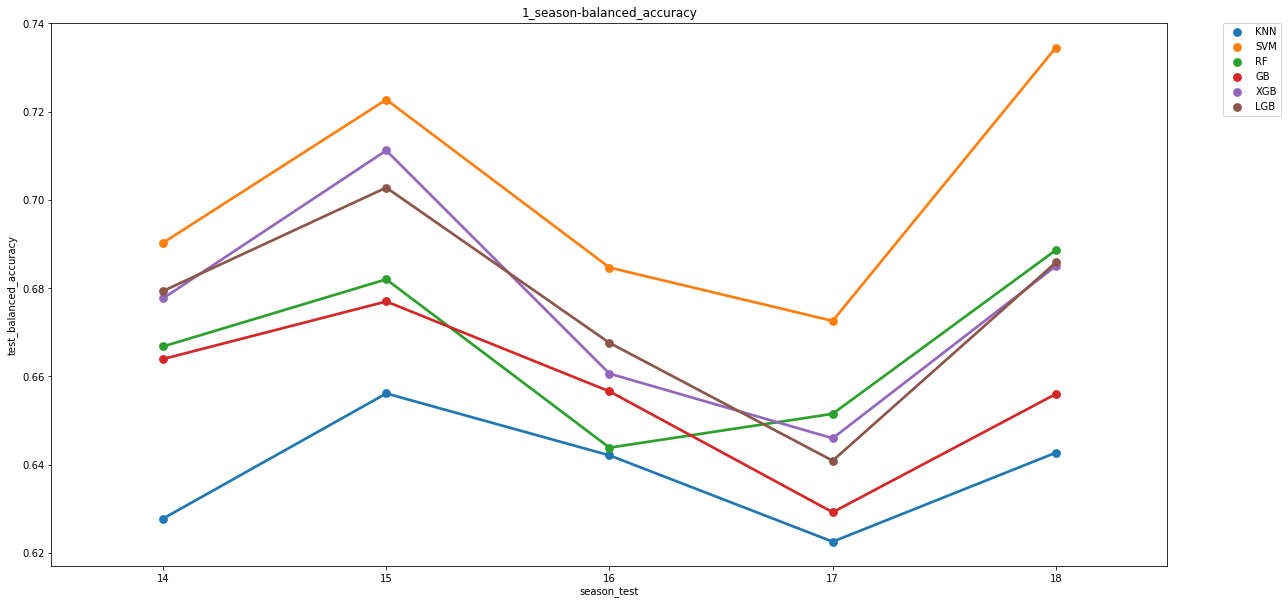

In [15]:
#### Visualize experiments results
#results_df = exp.plot_experiment_results(experiment_name, results)
#results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")
plot_results(experiment_name, results, figsize=(20,10))

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%.

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.6925515127344388 - 0.01854879007225907
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.6738674403149788 - 0.024290520850604853
    - ***LGB***: Obtuvo el tercer promedio mas alto. balanced_accuracy: 0.6726459601145429 - 0.022280716932570364
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment using StandardScaler

In [16]:
experiment_name = f"{exp_prefix}scaled_data"

In [17]:
folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y, True)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment scaled_data
KNN: balanced_accuracy: 0.6754298375027097 - 0.01928777264171135
SVM: balanced_accuracy: 0.6531617747424621 - 0.07899025362583809
RF: balanced_accuracy: 0.672157524455305 - 0.01738358898991774
GB: balanced_accuracy: 0.6600822404895346 - 0.02364539455991302
XGB: balanced_accuracy: 0.6783577588019277 - 0.02287207972097111
LGB: balanced_accuracy: 0.6753486643743398 - 0.0226201278190083
Done


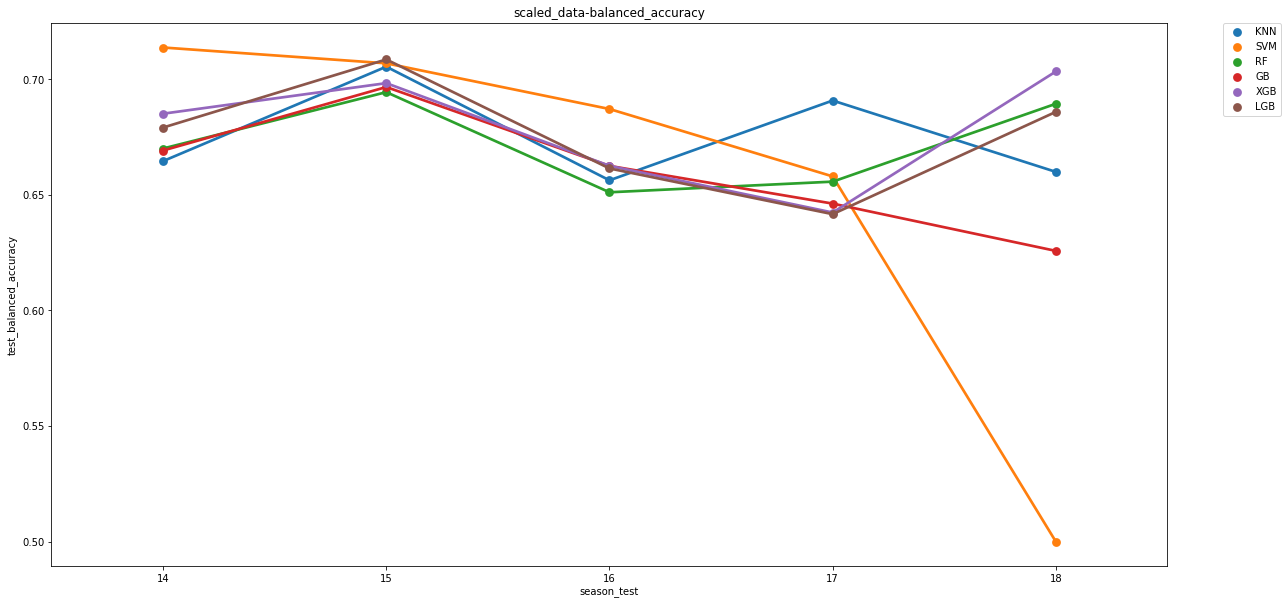

In [18]:
plot_results(experiment_name, results, figsize=(20,10))

Se observa lo siguiente:

- KSVM: continua siempre prediciendo true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%(como para las demas metricas que tambien estan balanceadas).

- Se observa como los algoritmos mas estables fueron:

    - ***LGB***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.6829856103519845 - 0.01684209164438598. LGB siendo entrenado con un dataset escalado evidencia una peque~a mejoria en estos resultados comparados con los anteriores(0.6726459601145429 - 0.022280716932570364). ***La cual desde mi punto de vista no es significativa.***
    - ***KNN***: Obtuvo el segundo promedio mas alto. 0.6792983447415086 - 0.0197533788391945.
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.667716032533138 - 0.027865425583437218. Tambien se observa que presenta una desviacion estandar mucho mas alta que los algoritmos anteriores.
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment: train: 2s; test: 1s

In [19]:
experiment_name = f"{exp_prefix}2_seasons"

In [20]:
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 2_seasons
KNN: balanced_accuracy: 0.6464884786815694 - 0.013508455213262984
SVM: balanced_accuracy: 0.7113810705038086 - 0.016598488478181884
RF: balanced_accuracy: 0.6699884915133651 - 0.009696147400815876
GB: balanced_accuracy: 0.6775780722910878 - 0.015123002567728807
XGB: balanced_accuracy: 0.6808086420991365 - 0.02349746951949679
LGB: balanced_accuracy: 0.6825646312431661 - 0.016204726311984087
Done


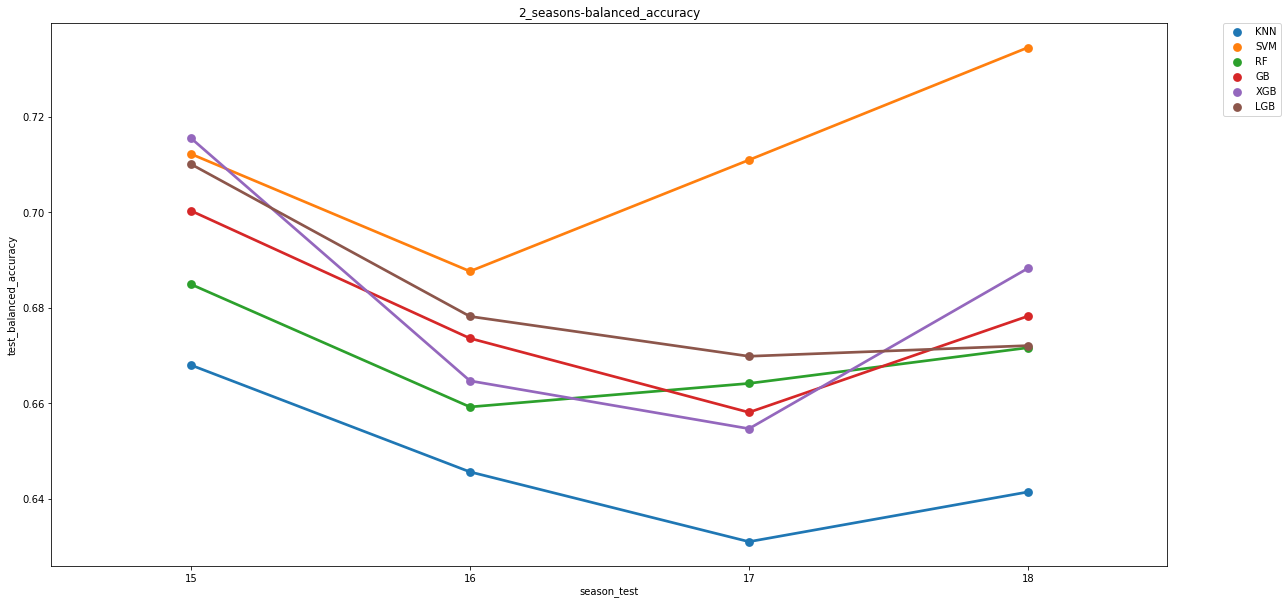

In [21]:
plot_results(experiment_name, results, figsize=(20,10))

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.7036452819063674 - 0.011312679852710191, incluso aun mejor que los experimentos anteriores(balanced_accuracy: 0.6925515127344388 - 0.01854879007225907)
    - ***LGB***: Obtuvo el segundo promedio mas alto. 0.6860596053592324 - 0.017356982173576504
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.6783107202886427 - 0.026668639103027844
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment: train: 3s; test: 1s

In [22]:
experiment_name = f"{exp_prefix}3_seasons"

In [23]:
folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3_seasons
KNN: balanced_accuracy: 0.6470004569471262 - 0.011484833137304142
SVM: balanced_accuracy: 0.7108136355383025 - 0.013518285319258734
RF: balanced_accuracy: 0.6715725429298951 - 0.010919228158797409
GB: balanced_accuracy: 0.6777990304094678 - 0.01133955186267115
XGB: balanced_accuracy: 0.6789360029990448 - 0.006787112029749886
LGB: balanced_accuracy: 0.6830667380221006 - 0.006457013711939624
Done


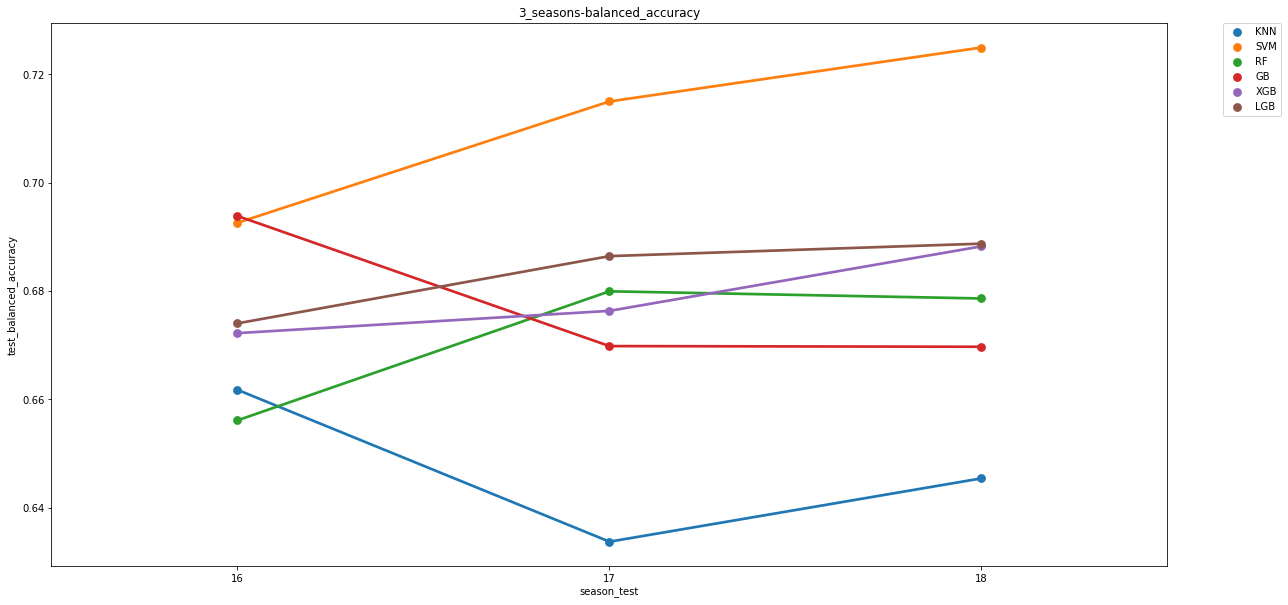

In [24]:
plot_results(experiment_name, results, figsize=(20,10))

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en cada una de las metricas. Cabe destacar tambien que fue el algoritmo con mejor desviacion estandar. balanced_accuracy: 0.7036452819063674 - 0.011312679852710191, incluso aun mejor que los experimentos anteriores(balanced_accuracy: 0.6925515127344388 - 0.01854879007225907)
    - ***LGB***: Obtuvo el segundo promedio mas alto. 0.6860596053592324 - 0.017356982173576504
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.6783107202886427 - 0.026668639103027844
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment train: 3q ; test: 1q

In [25]:
experiment_name = f"{exp_prefix}3q_1q"

In [26]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 3q_1q
KNN: balanced_accuracy: 0.6321856181667611 - 0.0345684665538887
SVM: balanced_accuracy: 0.663371922834871 - 0.07850845083452153
RF: balanced_accuracy: 0.6588674926363316 - 0.036463382579926366
GB: balanced_accuracy: 0.6450437237187986 - 0.03227379604235826
XGB: balanced_accuracy: 0.6555483608348491 - 0.03726999675775272
LGB: balanced_accuracy: 0.6603600519227778 - 0.039865558990251966
Done


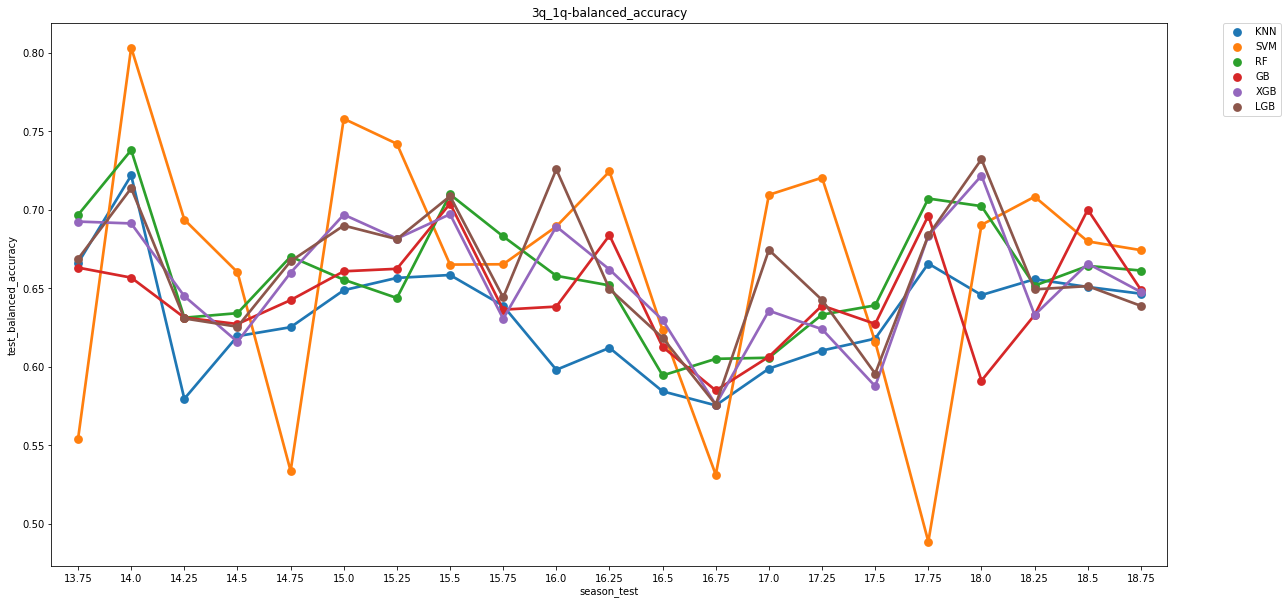

In [27]:
plot_results(experiment_name, results, figsize=(20,10))

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy pero a su vez fue el algoritmo con la desviacion estandar mas alta tambien. 0.7052866631416359 - 0.07373990913507918
    - ***LGB***: Obtuvo el segundo promedio mas alto. 0.6821197003531208 - 0.04791749773702776
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.6817549637812932 - 0.04870051822135649
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment train: 4q ; test: 2q

In [28]:
experiment_name = f"{exp_prefix}4q_2q"

In [ ]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

Running experiment 4q_2q
KNN: balanced_accuracy: 0.6383548455549363 - 0.024813827698705417
SVM: balanced_accuracy: 0.7025632945586987 - 0.042493577639238764


In [ ]:
plot_results(experiment_name, results, figsize=(20,10))

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy, inclusive de todos los experimentos este es el mas alto resultado. 0.7556939751261598 - 0.011406877715782774
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.7119226350413443 - 0.019108821398317707
    - ***XGB***: Obtuvo el tercer promedio mas alto. 0.7037161334648927 - 0.023074904030555104
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment remove first 1q ; train: 2q ; test: 1q

In [ ]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [ ]:
folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip=[0.25])
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, exp.get_models(), folds, train_seasons, test_seasons, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

In [ ]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

- Se observa como los algoritmos mas estables fueron:

    - ***SVM***: Fue algoritmo que alcanzo el promedio mas alto en la metrica de balanced_accuracy pero con una desviacion estandar mas alta que los siguientes algoritmos en el top del promedio mas alto. 0.6514141774238262 - 0.05234245335081721
    - ***XGB***: Obtuvo el segundo promedio mas alto. 0.632512284207538 - 0.04033560641373664
    - ***RF***: Obtuvo el tercer promedio mas alto. 0.6302538460680835 - 0.04531897469391061
    

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

## Experiments comparison

In [ ]:
utils.serialize_object(exp_group_name, exp.exp_results)

In [ ]:
exp_df = pd.DataFrame(exp.exp_results)

In [ ]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [ ]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

In [ ]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

Se observa:

- El algoritmo SVM fue el que obtuvo el mejor rendimiento.
- Se obtuvo mejor rendimiento utilizando 
    
    

## Plot experiment results

In [ ]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Balance Accuracy

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

In [ ]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

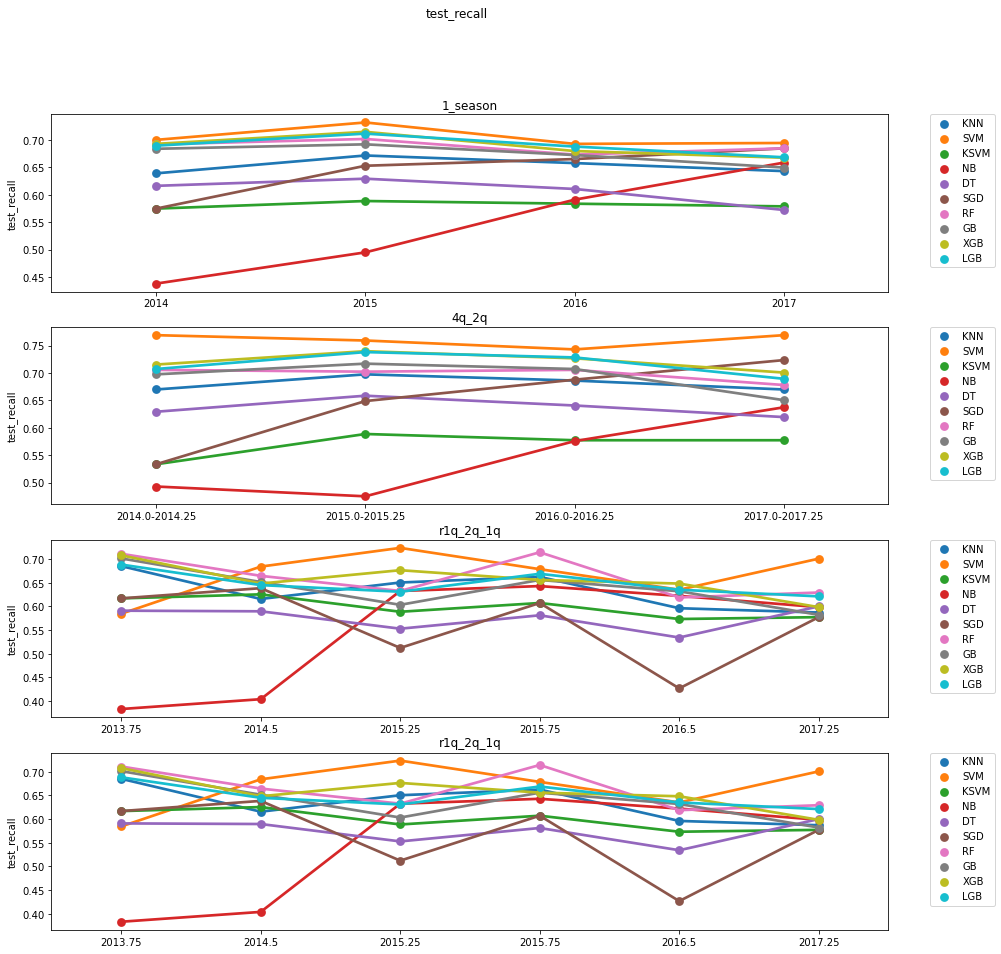

In [40]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

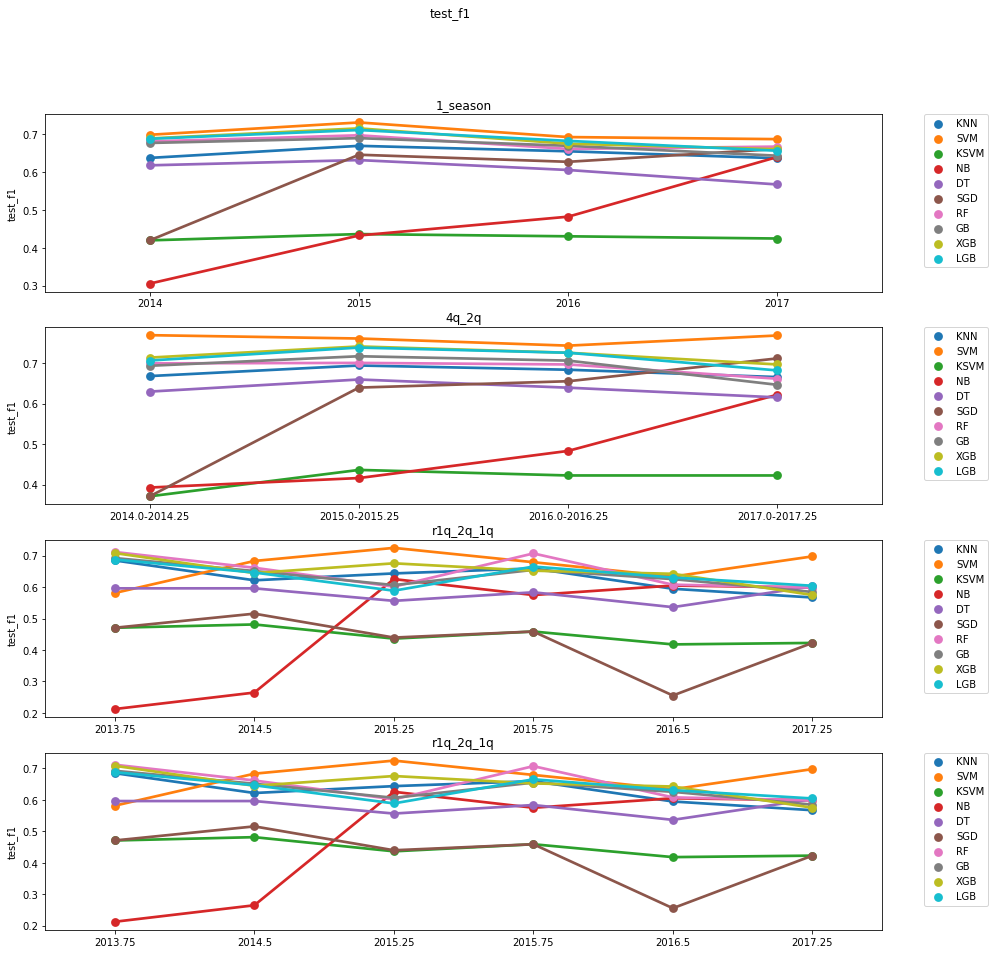

In [41]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

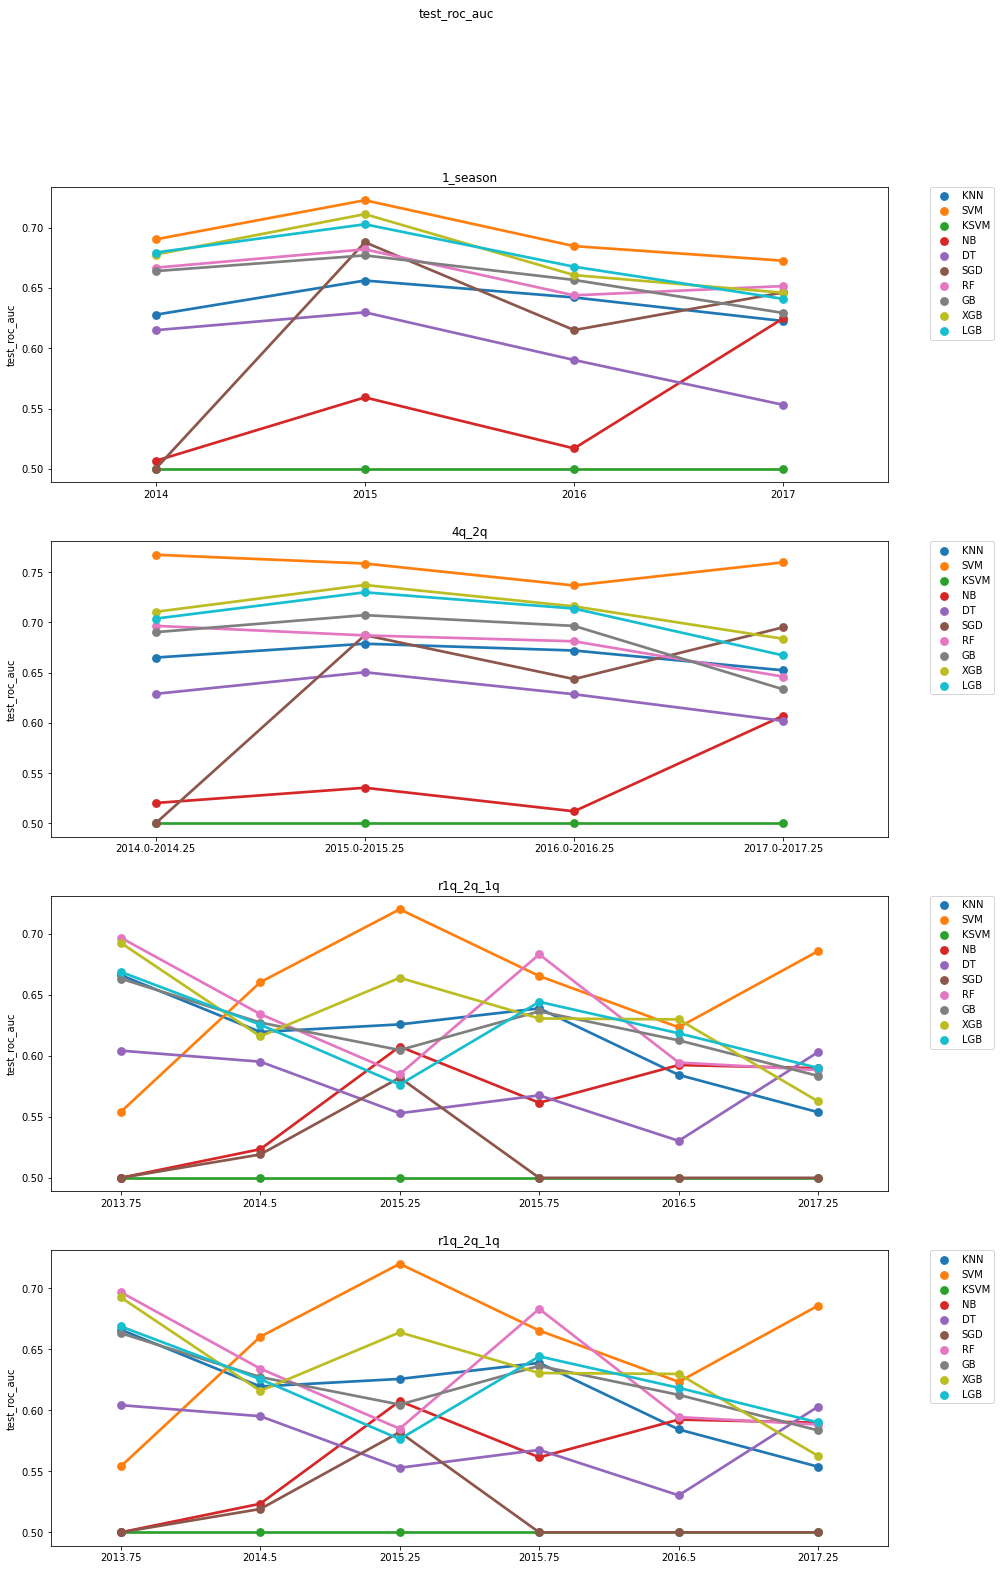

In [42]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Test a specific model

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])